**Importar las funciones necesarias para realizar la exploración**

In [51]:
import random
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import string
import contractions
from collections import Counter

**Función para estandarizar frases**

In [53]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocesar_frase(frase):
    frase = frase.lower()  # Convertir a minúsculas
    frase = contractions.fix(frase)  # Expandir contracciones
    frase = re.sub(r'["\'“”‘’``...]', '', frase)
    tokens = word_tokenize(frase)  # Tokenizar frase
    tokens = [palabra for palabra in tokens if palabra not in string.punctuation] #Eliminar signos de puntuación
    tokens = [palabra for palabra in tokens if palabra not in stop_words] #Eliminar palabras superfluas
    tokens = [palabra for palabra in tokens if palabra != "'s" and palabra != "s'"] #Eliminar apóstrofe
    
    # Obtener las etiquetas gramaticales
    etiquetas = nltk.pos_tag(tokens)
    
    # Lematizar
    tokens_lemmatizados = [
        lemmatizer.lemmatize(palabra, obtener_etiqueta(etiqueta)) for palabra, etiqueta in etiquetas
    ]
    
    return ' '.join(tokens_lemmatizados)

**Función para seleccionar frase de cada review**

In [55]:
def seleccionar_frase(oraciones_reseña, tiene_spoiler):
    frases_con_spoiler = [oracion for es_spoiler, oracion in oraciones_reseña if es_spoiler == 1]
    if tiene_spoiler and frases_con_spoiler:
        return random.choice(frases_con_spoiler)
    else:
        return random.choice([oracion for _, oracion in oraciones_reseña])


**Obtener la etiqueta asociada a la palabra**

In [57]:
def obtener_etiqueta(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN


In [59]:
ruta_archivo = 'C:/Users/Daniel/Documents/Universidad/Semestre 10/Proyectos Estadísticos/goodreads_reviews_spoiler.json/goodreads_reviews_spoiler.json'

In [61]:
maximo_reseñas = 1000000
tamaño_chunk = 1000

**Recorrido de la base de datos y el procesado de texto**

In [65]:
datos_reseñas = []
for chunk in pd.read_json(ruta_archivo, lines=True, chunksize=tamaño_chunk):
    for _, fila in chunk.iterrows():
        if len(datos_reseñas) >= maximo_reseñas:
            break
        
        frase_clave = seleccionar_frase(fila['review_sentences'], fila['has_spoiler'])
        etiqueta = fila['has_spoiler']
        datos_reseñas.append((frase_clave, etiqueta))
    
    if len(datos_reseñas) >= maximo_reseñas:
        break

**Creación Dataframe**

In [67]:
df_reseñas = pd.DataFrame(datos_reseñas, columns=['texto', 'etiqueta'])
df_reseñas['texto'] = df_reseñas['texto'].apply(preprocesar_frase)

**Frecuencia de palabras**

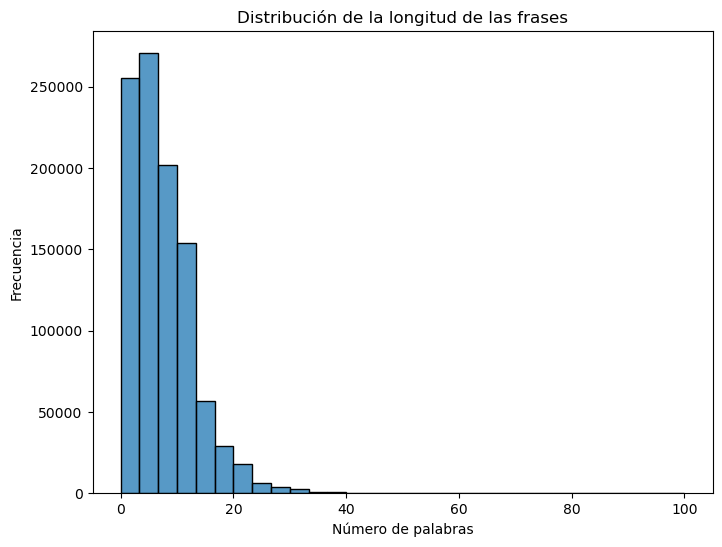

In [69]:
df_reseñas['largo'] = df_reseñas['texto'].apply(lambda x: len(x.split()))
plt.figure(figsize=(8, 6))
sns.histplot(df_reseñas['largo'], bins=30)
plt.title('Distribución de la longitud de las frases')
plt.xlabel('Número de palabras')
plt.ylabel('Frecuencia')
plt.show()

**Longitud frases**

In [71]:
spoiler_largo = df_reseñas[df_reseñas['etiqueta'] == 1]['largo'].mean()
no_spoiler_largo = df_reseñas[df_reseñas['etiqueta'] == 0]['largo'].mean()
print(f"Longitud media de frases con spoilers: {spoiler_largo:.2f} palabras")
print(f"Longitud media de frases sin spoilers: {no_spoiler_largo:.2f} palabras")

Longitud media de frases con spoilers: 9.65 palabras
Longitud media de frases sin spoilers: 7.23 palabras


**Nube de palabras**

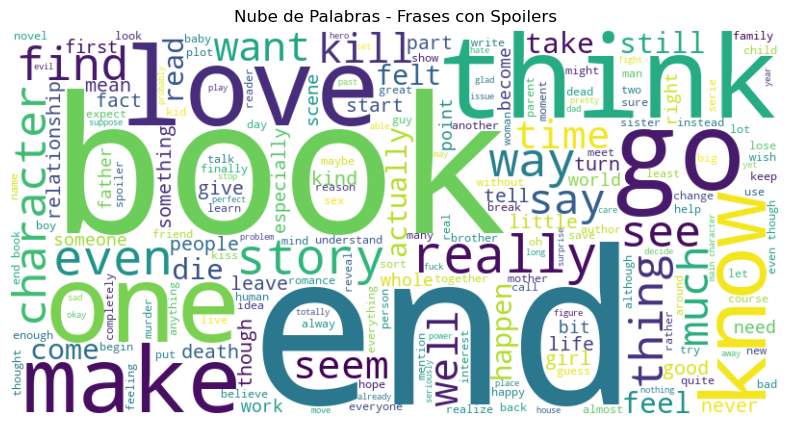

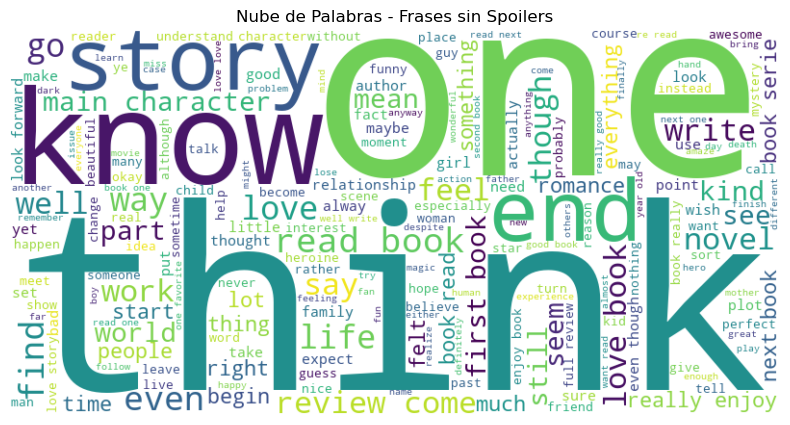

In [73]:
texto_spoiler = ' '.join(df_reseñas[df_reseñas['etiqueta'] == 1]['texto'])
texto_no_spoiler = ' '.join(df_reseñas[df_reseñas['etiqueta'] == 0]['texto'])


# Nube de palabras - spoilers
wordcloud_spoiler = WordCloud(width=800, height=400, background_color='white').generate(texto_spoiler)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_spoiler, interpolation='bilinear')
plt.title('Nube de Palabras - Frases con Spoilers')
plt.axis('off')
plt.show()

# Nube de palabras - no spoilers
wordcloud_no_spoiler = WordCloud(width=800, height=400, background_color='white').generate(texto_no_spoiler)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_no_spoiler, interpolation='bilinear')
plt.title('Nube de Palabras - Frases sin Spoilers')
plt.axis('off')
plt.show()

**Gráfico circular**

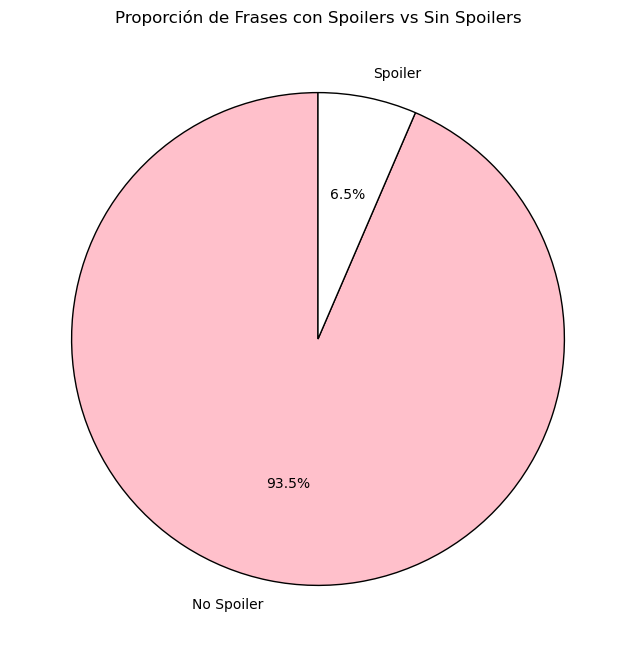

In [85]:
plt.figure(figsize=(8, 8))
df_reseñas['etiqueta'].value_counts().plot.pie(
    labels=["No Spoiler", "Spoiler"],
    autopct='%1.1f%%',
    colors=['pink', 'white'],
    startangle=90,
    wedgeprops={'edgecolor': 'black'}
)
plt.title('Proporción de Frases con Spoilers vs Sin Spoilers')
plt.ylabel('')
plt.show()

**Palabras más utilizadas por categoría**

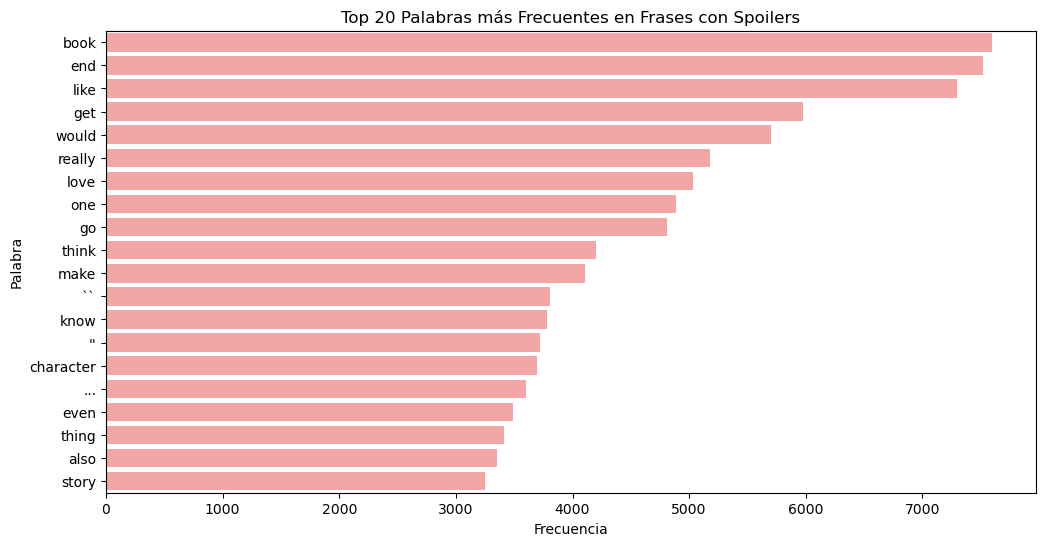

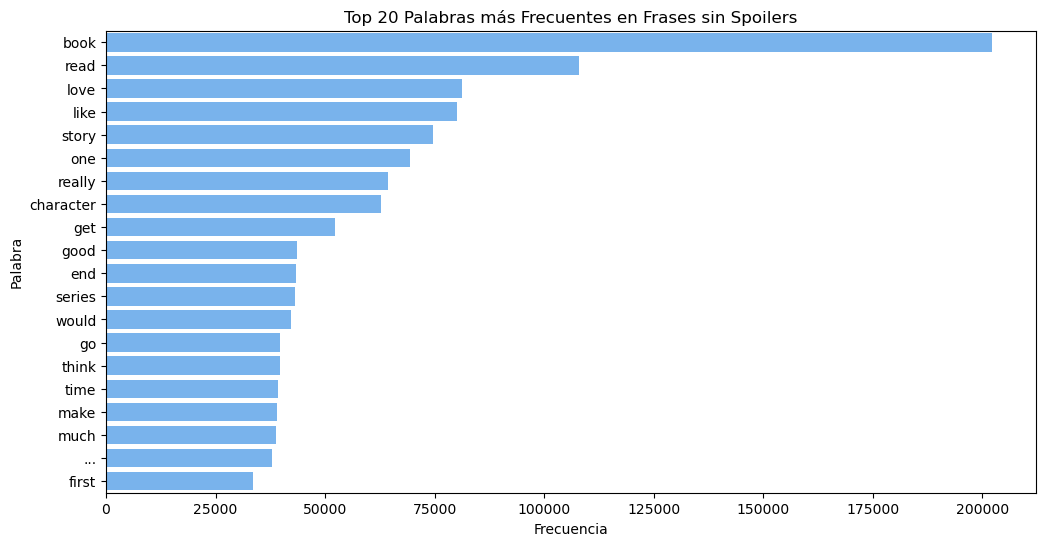

In [89]:
spoiler_palabras = ' '.join(df_reseñas[df_reseñas['etiqueta'] == 1]['texto']).split()
no_spoiler_palabras = ' '.join(df_reseñas[df_reseñas['etiqueta'] == 0]['texto']).split()

top_n = 20
contador_spoiler = Counter(spoiler_palabras)
contador_no_spoiler = Counter(no_spoiler_palabras)

# Obtener las palabras más comunes
palabras_spoiler = pd.DataFrame(contador_spoiler.most_common(top_n), columns=['Palabra', 'Frecuencia'])
palabras_no_spoiler = pd.DataFrame(contador_no_spoiler.most_common(top_n), columns=['Palabra', 'Frecuencia'])

# Gráfico de palabras frecuentes - Spoilers
plt.figure(figsize=(12, 6))
sns.barplot(x='Frecuencia', y='Palabra', data=palabras_spoiler, color='#ff9999')
plt.title(f'Top {top_n} Palabras más Frecuentes en Frases con Spoilers')
plt.show()

# Gráfico de palabras frecuentes - No Spoilers
plt.figure(figsize=(12, 6))
sns.barplot(x='Frecuencia', y='Palabra', data=palabras_no_spoiler, color='#66b3ff')
plt.title(f'Top {top_n} Palabras más Frecuentes en Frases sin Spoilers')
plt.show()